Judgements is nice.
This is turning into more of a (otteny) theorem prover. hmmm.

Really maybe I just wanted apply


A partial proof tree has multiple hole. Searches for holes should share remainiing holes.
DOn't use just a list of all partial proof trees. Interpolate the list

https://github.com/LPCIC/elpi/blob/master/src/compiler.ml
https://github.com/andrejbauer/plzoo/blob/master/src/miniprolog/solve.ml

https://www.philipzucker.com/harrop-checkpoint/

```ocaml
type judgement

type trail = 
    | Choice of goal * trail (* a different goal to try and trail to reinstate (which could be more Choice ) *) 
    | 

type cont = {  next : goal;  fail: goal * cont}
type cont = {goals : judgement list; 
             fail : judgement * cont}
type cont = {
    goals : judgement list;
    success : cont;
    fail : cont
}
type cont = {
    success : (judgement * cont) option
    fail : (judgement * cont) option
}


  
```

https://drops.dagstuhl.de/storage/01oasics/oasics-vol058_iclp2017/OASIcs.ICLP.2017.10/OASIcs.ICLP.2017.10.pdf
https://www.youtube.com/watch?v=SRYAMt8iQSw&list=PLJq3XDLIJkib2h2fObomdFRZrQeJg4UIW&ab_channel=softdevteamuk Paul Tarau @ VMSS16: A Simplified Virtual Machine for Multi-Engine Prolog

A superposition of different proof trees. It's kind of like egraph / vsa / multiterm. Hmm.
a vsa list of goals.

type  goals =  Choice goal * goals | Conj goal * gone | Top
type goals = Choice of goal list * goals | Conj of goal list * goals | Top
     Choice of (goal * goals) list
If it was kind of like dnf / cnf, this is the unexpanded for of that
type goal = Disj of goal

("choice", )

What about Max's thing about dynamically recpatruing sharing in the stack.


http://adam.chlipala.net/papers/MakamICFP18/MakamICFP18.pdf Makam

One advantage of operating over z3 syntax tree is we get a CLP by default. CLP(SMT)
Mark some of the predicates as interpreted. 

maybe a lark parser for prolog rules?


In [ ]:
from z3 import *
import lark.tree
# Grammar for parsing
grammar = """
    start: rule+
    rule: predicate ":-" premises "."
    predicate: ID "(" args ")"
    premises: predicate ("," predicate)*
    args: (ID | expr) ("," (ID | expr))*
    expr: ID "(" args ")"

    %import common.CNAME -> ID
    %import common.WS
    %ignore WS
"""
from lark import Lark, Transformer, Tree
parser = Lark(grammar, start='rule')
parser.parse("a(X) :- b(X), c(X).")

def interp_rule(t):
    selects = []
    froms = []
    wheres = []
    env = {}
    match Tree("rule", head, body):
    for i, premise in enumerate(body):
        row = premise.head + "_" + str(i)
        froms.append(f"{premise.head} AS {premise.head}_{i}")
        for arg in args:
        match arg enumerate(args):
            entry = row + ".x" + {i}
            case Tree("ID", name):
                if name in env:
                    wheres.append(f"{} = {env[name]})
                else:
                    selects.append(name)
            
            case
    if var in env:
        return env[var]
    else:
        env[v] = 
        return var
    match Tree("predicate", name, args):



Tree(Token('RULE', 'rule'), [Tree(Token('RULE', 'predicate'), [Token('ID', 'a'), Tree(Token('RULE', 'args'), [Token('ID', 'X')])]), Tree(Token('RULE', 'premises'), [Tree(Token('RULE', 'predicate'), [Token('ID', 'b'), Tree(Token('RULE', 'args'), [Token('ID', 'X')])]), Tree(Token('RULE', 'predicate'), [Token('ID', 'c'), Tree(Token('RULE', 'args'), [Token('ID', 'X')])])])])

In [45]:
from lark import Lark, Transformer, Tree
from z3 import *
import lark.tree
grammar = """
start: (rule | decl)+
decl: ID ":" typ "."
typ: "(" typ ")" -> typ
    | ID  -> tconst
    | typ ("->" | "→") typ -> tarrow
rule: expr ":-" premises "."
premises: expr ("," expr)*
expr : ID atom+ -> f_app 
      | atom -> atom
atom : ID 
      | "(" expr ")" -> expr 


%import common.CNAME -> ID
%import common.WS
%ignore WS
"""

example = """
term : type.
typ : type.
app : term -> term -> term.
arrow : typ -> typ -> typ.
lam : typ -> (term -> term) -> term.
typeof : term -> typ → prop.
typeof (app E1 E2) T1 :- typeof E1 (arrow T T1), typeof E2 T.

"""
#typeof (lam T1 E) (arrow T1 T2) :- (x:term -> typeof x T1 -> typeof (E x) T2).


def interp_typ(t):
    print(t)
    match t:
        case Tree("typ", [t]):
            return interp_typ(t)
        case Tree('tconst', [ID]):
            ID = str(ID)
            if ID == 'prop':
                return BoolSort()
            else:
                return DeclareSort(str(ID))
        case Tree('tarrow', [t1, t2]):
            return ArraySort(interp_typ(t1), interp_typ(t2))
     
def interp(t : Tree):
    assert t.data == 'start'
    env = {}
    rules = []
    def term(t):
        match t:
            case Tree("expr", [e]): return term(e)
            case Tree("atom", [ID]): return env[str(ID)]
            case Tree("f_app", [ID, *consts]):
                print(env[str(ID)], t)
                return env[str(ID)][tuple(term(c) for c in consts)]

    for c in t.children:
        match c:
            case Tree('decl', [ID, typ]):
                env[str(ID)] = Const(str(ID), interp_typ(typ))
            case Tree('rule', [head, premises]):
                rules.append((term(head), [term(p) for p in premises]))
    return env, rules

parser = Lark(grammar, start='start')
tree = parser.parse(example)
#print(tree.pretty())
interp(tree)



Tree('tconst', [Token('ID', 'type')])
Tree('tconst', [Token('ID', 'type')])
Tree('tarrow', [Tree('tarrow', [Tree('tconst', [Token('ID', 'term')]), Tree('tconst', [Token('ID', 'term')])]), Tree('tconst', [Token('ID', 'term')])])
Tree('tarrow', [Tree('tconst', [Token('ID', 'term')]), Tree('tconst', [Token('ID', 'term')])])
Tree('tconst', [Token('ID', 'term')])
Tree('tconst', [Token('ID', 'term')])
Tree('tconst', [Token('ID', 'term')])
Tree('tarrow', [Tree('tarrow', [Tree('tconst', [Token('ID', 'typ')]), Tree('tconst', [Token('ID', 'typ')])]), Tree('tconst', [Token('ID', 'typ')])])
Tree('tarrow', [Tree('tconst', [Token('ID', 'typ')]), Tree('tconst', [Token('ID', 'typ')])])
Tree('tconst', [Token('ID', 'typ')])
Tree('tconst', [Token('ID', 'typ')])
Tree('tconst', [Token('ID', 'typ')])
Tree('tarrow', [Tree('tarrow', [Tree('tconst', [Token('ID', 'typ')]), Tree('typ', [Tree('tarrow', [Tree('tconst', [Token('ID', 'term')]), Tree('tconst', [Token('ID', 'term')])])])]), Tree('tconst', [Token('ID',

KeyError: 'E1'

Tree(Token('RULE', 'predicate'), [Token('ID', 'typeof'), Tree(Token('RULE', 'args'), [Tree(Token('RULE', 'expr'), [Token('ID', 'app'), Tree(Token('RULE', 'args'), [Token('ID', 'E1'), Token('ID', 'E2')])]), Token('ID', 'T')])])
Tree(Token('RULE', 'predicate'), [Token('ID', 'typeof'), Tree(Token('RULE', 'args'), [Token('ID', 'E1'), Tree(Token('RULE', 'expr'), [Token('ID', 'arrow'), Tree(Token('RULE', 'args'), [Token('ID', 'T'), Token('ID', 'T')])])])])
Tree(Token('RULE', 'predicate'), [Token('ID', 'typeof'), Tree(Token('RULE', 'args'), [Token('ID', 'E2'), Token('ID', 'T')])])
start
  rule
    predicate
      typeof
      args
        expr
          app
          args
            E1
            E2
        T
    premises
      predicate
        typeof
        args
          E1
          expr
            arrow
            args
              T
              T
      predicate
        typeof
        args
          E2
          T



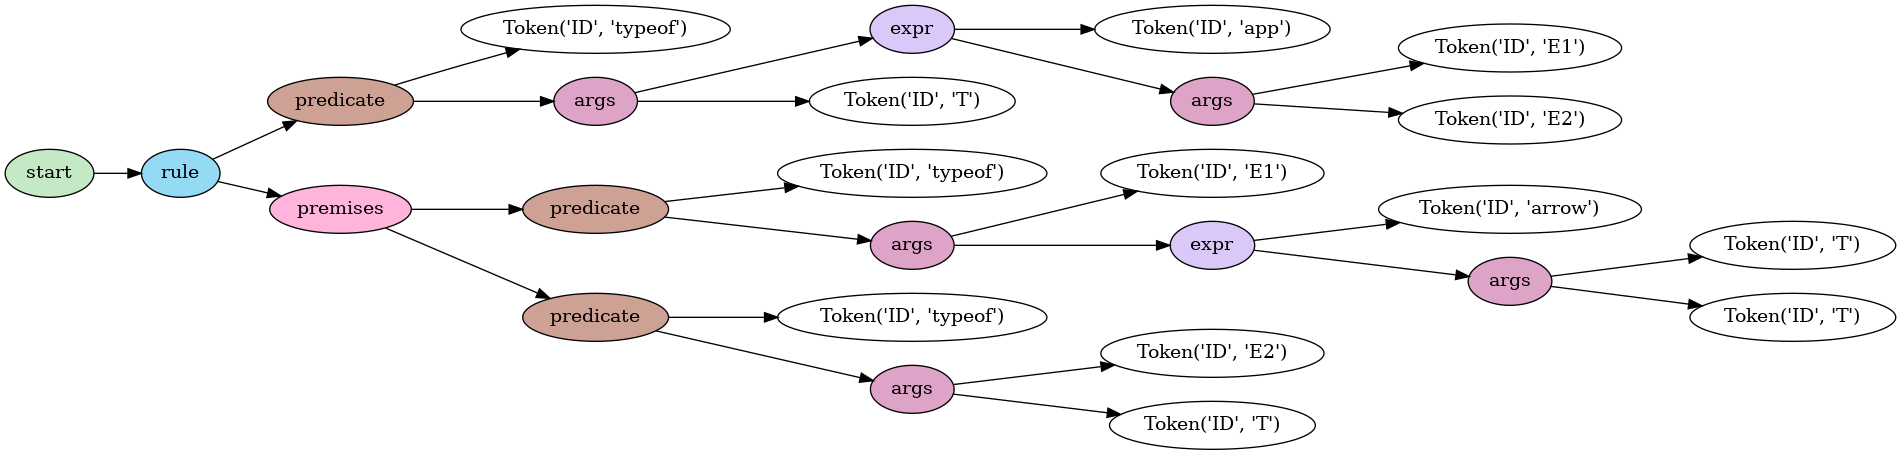

In [9]:

from lark import Lark, Transformer, Tree
from z3 import *
import lark.tree
# Grammar for parsing
grammar = """
start: rule+
rule: predicate ":-" premises "."
predicate: ID "(" args ")"
premises: predicate ("," predicate)*
args: (ID | expr) ("," (ID | expr))*
expr: ID "(" args ")"

%import common.CNAME -> ID
%import common.WS
%ignore WS
"""

term = DeclareSort("term")
typ = DeclareSort("typ")


# Parse and interpret Prolog rule
parser = Lark(grammar, start='start')
tree = parser.parse("typeof(app(E1, E2), T) :- typeof(E1, arrow(T, T)), typeof(E2, T).")

Tree.__match_args__ = ("data", "children")
def interp(tree):
    match tree:
        case Tree("start", rules):
            for rule in rules:
                interp(rule)
        case Tree("rule", [pred, premises]):
            print(pred)
            for premise in premises.children:
                print(premise)
        case _:
            print(tree)
interp(tree)
from IPython.display import Image, display
print(tree.pretty())
#https://stackoverflow.com/questions/4596962/display-graph-without-saving-using-pydot
Image(lark.tree.pydot__tree_to_graph(tree).create_png())


In [ ]:
# Convert parse tree to Z3
#transformer = PrologToZ3()
#z3_expr = transformer.transform(tree)
"""
# Transformer to interpret parsed Prolog rules
class PrologToZ3(Interpreter):
    def __init__(self):
        self.env = {"typeof": Function('typeof', term, typ, BoolSort()),
           "app": Function('app', term, term, term),
           "arrow": Function('arrow', typ,typ, typ)}
    def type_decl(self, items):
        return Function('typeof', term, typ, BoolSort())
    def const_decl(self, items):
        const_env[str(items[0])] = Function("")
    def predicate(self, items):
        func_name = str(items[0])
        args = items[1:]
        return self.env[func_name](*args)

    def ID(self, token):
        if str.isupper():
            return Const(token, typ)
        else:
            return self.env[token]
"""

In [ ]:
term = DeclareSort("term")
typ = DeclareSort("typ")

app = Function("app", term, term, term)
arrow = Function("arrow", typ, typ, typ)

lam = Function("lam", term, (ArraySort(term, term)), term)
typeof = Function("typeof", term, typ, BoolSort())

kd.axiom(kd.QForAll([X, Y, Z], 
                    typeof(E1, arrow(T, T1)), typeof(E2,T)
                    , arrow(app(E1, E2), T1)))



In [ ]:
class Rule(NamedTuple):
    vs: list[smt.ExprRef]
    head: smt.BoolRef
    body: list[smt.BoolRef]

# could use z3 datalog
# also could use z3 bounded horn clause?
def datalog(smt.ExprRef) -> :

In [ ]:
def right(subst, avs, ectx, db, goal):
    if smt.is_true(goal):
        return subst
    elif smt.is_false(goal):
        return None
    elif smt.is_and(goal): # Rand
        for subst in right(subst, db, goal.arg(0)):
            yield from right(subst, db, goal.arg(1))
    elif smt.is_or(goal): #Ror
        # could interleave
        yield from right(subst, db, goal.arg(0))
        yield from right(subst, db, goal.arg(1))
    elif smt.is_implies(goal): #Rimpl
        yield from right(subst, avs,ectx, db + [goal.arg(0)], goal.arg(1))
    elif smt.is_quantifier(goal):
        if goal.is_forall(): #Rforall
            vs, body = open_binder(goal)
            avs.extend(vs)
            yield from right(subst, avs, ectx, db, body)
        elif goal.is_exists(): #Rexists
            vs, body = open_binder(goal)
            acpy = avs.copy()
            for v in vs:
                ectx[v] = acpy # allowed universal variables
            yield from right(subst, avs, ectx, db, body)
        else:
            raise Exception("unexpected quantifier in goal", goal)
    elif smt.is_app(goal):
        yield from decide(subst, avs, ectx, db, goal)
    else:
        raise Exception("unexpected goal", goal)

def decide(subst, avs, ectx, db, goal):
    for focus in db:
        yield from left(subst, avs, ectx, db, focus, goal)

def left(subst, ectx, db, focus, goal):
    if smt.is_and(focus):
        for c in focus.children():
            yield from left(subst, ectx, db, c, goal)
    elif smt.is_implies(focus):
        for subst in right(subst, ectx, db, focus.arg(1)):
            yield from left(subst, ectx, db, focus.arg(0), goal)
    elif smt.is_quantifier(focus):
        if focus.is_forall():
            vs, body = open_binder(focus)
            for v in vs:
                ectx[v] = None # can contain anything? sort of distinction of unification variables from db vs goal. Top value in avar lattice
            yield from left(subst, avars, db, body, goal)
        else:
            raise Exception("unexpected quantifier in focus", focus)
    elif smt.is_app(focus):
        # immediately apply subst to... ? Just need a unify that accepts starting subst. Either immiedately apply inb unify or here.
        # substitute(goal, subst); subst1; unify(ectx, focus, goal); yield subst + subst1
        return unify(subst, ectx, focus, goal) # yield from if unify returns multiple results
    else:
        raise Exception("unexpected focus", focus)


def query(db, vs, goal):
    yield from right({}, [], {v:[] for v in vs}, db, goal)
# instead of carrying subst, we could immiedatiely use it.
# big loop isn't great because we don't have a single subst 

# "occurs check" is ||= typing relation
# sigma is ectx
# diswllowed is avars - ectx



In [ ]:
# applpy ins in focussed mode. We break down d and return al istg of remaining judgements
def apply(d, g):
    vs = []
    #ctx = []
    goals = []
    while True:
        subst = unify(vs,d,g)
        if subst is not None:
            return subst, goals
        elif is_forall(d):
            vs1, d = open_binder(d)
            vs.extend(vs1)
        elif is_implies(d):
            goals.append(d.arg(0))
            d = d.arg(1)
        else:
            return None






The Exists formulation of unification is R rules on _goal_.

Forall matching is backchaing after decided.

In [ ]:
def z3_match(
    t: smt.ExprRef, pat: smt.ExprRef
) -> Optional[dict[smt.ExprRef, smt.ExprRef]]:
    vs = []
    subst = {}
    todo = [(t, pat)]
    while len(todo) > 0:
        t, pat = todo.pop()
        if t.eq(pat):
            continue
        if smt.is_quantifier(pat) and pat.is_forall():
            vs1, pat = open_binder(pat)
            vs.extend(vs1)
            todo.append((t, pat))
            continue
        if pat in vs:
            if pat in subst:
                if not subst[pat].eq(t):
                    return None
            else:
                subst[pat] = t
            continue
        elif smt.is_app(t) and smt.is_app(pat):
            if pat.decl() == t.decl():
                todo.extend(zip(t.children(), pat.children()))
            else:
                return None
        else:
            raise Exception("Unexpected subterm or subpattern", t, pat)
    return subst

# fill them in, reduce both. Matching modulo R.
def bottom_match(vs, t, pat):
    sterms = set(subterms(t))
    for ts in itertools.product(*[[s for s in sterms if s.sort().eq(v.sort()) ] for v in vs]): # but filtered by type
        t1 = substitute(pat,*zip(vs,ts))
        #if t1.eq(t): # single term match
        #    return dict(zip(vs,ts))
        if t1 in sterms: # all subterms match
            yield zip(vs,ts), t1




In [ ]:

type searchstate = tuple[Literal["choice", list[searchstate]]]




In [1]:
from kdrag.all import *

from typing import NamedTuple
# each of these are _judgments_
# a state of leaves of a proof tree.

class Focused(NamedTuple):
    focus : smt.ExprRef
    goal: smt.BoolRef
    subst: dict[smt.ExprRef, smt.ExprRef]
    ctx: list[smt.BoolRef]

class Unfocused():
    goal: 


type Judgement = Focused | Unfocused

type ProofLeaves = list[Judgement]

class PartialProof(NamedTuple):
    judgements : list[Judgement]
    subst : dict[]


def harrop():
    partial_proofs : list[ProofLeaves] = [[ Unfocused({}, rules, goal) ]]
    while partial_proofs:
        leaves = partial_proofs.pop()
        j = judgements.pop()
        match j:
            case Focused():
            
            case Unfocused(subst, rules, goal):
                if is_and(goal):
                    for g in goal.children():
                        judgements.append( Unfocused(subst, rules, g))
                elif is_or(goal):
                    for g in goal.children():
                        partial_proofs.append(subst, judgements + [Unfocused(subst, rules, g)])
                elif is_implies(goal):







def backchain(ctx, goal):
    if smt.is_and(goal):
        for g in goal.children():
            backchain(ctx, g)
    elif smt.is_or(goal):


    goalstack = [( db, subst,[goal])] # goal stack is kind of a DNF
    while goalstack:
        goals = goalstack.pop()
        while goals:
            goal = goals.pop()
            # right rules
            if smt.is_and(goal):
                goals.extend(goal.children())
            elif smt.is_or(goal):
                for g in goal.children():
                    goalstack.append(goals + [g])
            elif smt.is_implies(goal):
                db.append(goal.arg(0))
                goals.append(goal.arg(1))
            else:
                # decide / select
                for d in db:




def backchain(ctx, goal):
    if smt.is_and(goal):
        for g in goal.children():
            backchain(ctx, g)
    elif smt.is_or(goal):
        for g in goal.children():
            backchain(ctx, g)
    elif smt.is_implies(goal):
        backchain(ctx, goal.children()[1])
    else:
        print(goal)
        print(ctx.check(goal))
        print(ctx.model())
        print()



def left(ctx, d, goal):
    if smt.is_and(goal):
        for g in goal.children():
            left(ctx, d, g)
    elif smt.is_or(goal):
        for g in goal.children():
            left(ctx, d, g)
    elif smt.is_implies(goal):
        left(ctx, d, goal.children()[0])
    else:
        print(goal)
        print(ctx.check(smt.And(d, goal)))
        print(ctx.model())
        print()



Admitting lemma ForAll([x, y, z], mul(x, mul(y, z)) == mul(mul(x, y), z))


Admitting lemma ForAll(x, Implies(x >= 0, sqrt(x) >= 0))
Admitting lemma ForAll(x, Implies(x >= 0, sqrt(x)**2 == x))
Admitting lemma ForAll(x, Implies(x >= 0, sqrt(sqr(x)) == x))
